In [1]:
import sys
sys.path.append('/scratch/gf332/Misc/BVAE/code')

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from tqdm import tqdm

from bnn import DummyBNN
from adaptive_sghmc_v2 import AdaptiveSGHMC
from sghmc import SGHMC

%matplotlib inline

tfd = tfp.distributions
tfl = tf.keras.layers

paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)

#plt.rc("text", usetex=True)
plt.rc("font", size=32.0, family="serif")
plt.rcParams["text.latex.preamble"] = [r"\usepackage{amsmath}"]

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
def f(x):
    return np.sinc(x * 10. - 5.)

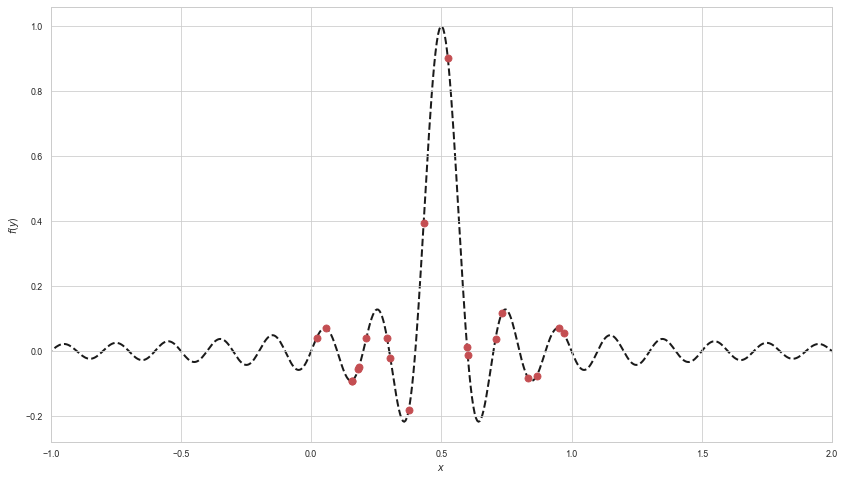

In [4]:
rng = np.random.RandomState(42)

num_points = 20

x = rng.rand(num_points).astype(np.float32)
y = f(x)

grid = np.linspace(-2., 3., 1000).astype(np.float32)
fvals = f(grid)

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(grid, fvals, linestyle='--', c='k', zorder=0)
ax.scatter(x, y, marker='o', c='r', zorder=1, s=50)

ax.set_xlim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

plt.show()

In [5]:
bnn = DummyBNN()
bnn.build(input_shape=(None, 1))

In [6]:
@tf.function
def train_step(model, batch, labels):

    with tf.GradientTape() as tape:
        
        data_size = tf.cast(num_points, tf.float32)
        
        pred = model(batch)
        
        likelihood = tfd.Normal(loc=pred, scale=tf.exp(0.5 * model.likelihood_log_var))
        log_likelihood = tf.reduce_mean(likelihood.log_prob(labels))
        
        var_prior_log_prob = model.var_prior.log_prob(tf.exp(model.likelihood_log_var)) / data_size
        
        weight_prior_log_prob = model.weight_prior_log_prob() / data_size
        
        loss = -(log_likelihood + weight_prior_log_prob + var_prior_log_prob)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return pred, log_likelihood, var_prior_log_prob, weight_prior_log_prob

In [7]:
batch_size = num_points
iterations = 20000
keep_every = 50
burnin = 4000
learning_rate = 1e-2
friction = 0.05

log_every = 2000

x_mean, x_var = tf.nn.moments(tf.convert_to_tensor(x), axes=[0])
x_std = tf.sqrt(x_var)
y_mean, y_var = tf.nn.moments(tf.convert_to_tensor(y), axes=[0])
y_std = tf.sqrt(y_var)

x_normalized = (x - x_mean) / x_std
y_normalized = (y - y_mean) / y_std

ds = tf.data.Dataset.from_tensor_slices((x_normalized[:, None], y_normalized[:, None]))
ds = ds.shuffle(500).repeat().batch(batch_size).prefetch(16)

optimizer = {
    "adaptive_sghmc": AdaptiveSGHMC(learning_rate=learning_rate,
                                    burnin=burnin,
                                    data_size=num_points,
                                    overestimation_rate=3.,
                                    initialization_rounds=10,
                                    friction=friction),
    
    "sghmc": SGHMC(learning_rate=1e-6,
                   data_size=num_points,
                   momentum_decay=friction),
    
    "adam": tf.optimizers.Adam(learning_rate=1e-3),
}["adaptive_sghmc"]

In [8]:
weight_samples = []

i = 0

for batch, labels in tqdm(ds.take(iterations), total=iterations):

    i = i + 1

    pred, ll, vplp, wplp = train_step(bnn,
                                      batch, 
                                      labels)
    
    if i >= burnin and i % keep_every == 0:
        weight_samples.append(bnn.get_weights())
        
    if i % log_every == 0:
        mse = tf.reduce_mean(tf.math.squared_difference(pred, labels))
        
        print(f"iteration {i}: "
              f"MSE: {mse:.6f}, "
              f"LL: {ll:.6f}, "
              f"weight prior LL: {wplp:.6f}, "
              f"var prior LL: {vplp:.6f}")

  0%|          | 1/20000 [00:02<13:15:16,  2.39s/it]

SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!
SGHMC hyperparameters initialized!


 10%|█         | 2078/20000 [00:06<00:32, 546.09it/s]

iteration 2000: MSE: 0.001082, LL: 0.841330, weight prior LL: -1.598524, var prior LL: -1.083235


 20%|██        | 4085/20000 [00:09<00:27, 578.59it/s]

iteration 4000: MSE: 0.000082, LL: 3.285211, weight prior LL: -1.825356, var prior LL: 0.499085


 31%|███       | 6113/20000 [00:13<00:23, 600.09it/s]

iteration 6000: MSE: 0.000054, LL: 3.404383, weight prior LL: -1.884033, var prior LL: 0.522145


 40%|████      | 8080/20000 [00:16<00:19, 609.57it/s]

iteration 8000: MSE: 0.000034, LL: 3.581324, weight prior LL: -1.963358, var prior LL: 0.438028


 51%|█████     | 10106/20000 [00:19<00:16, 590.25it/s]

iteration 10000: MSE: 0.000055, LL: 3.410824, weight prior LL: -2.107167, var prior LL: 0.529924


 60%|██████    | 12080/20000 [00:23<00:13, 604.76it/s]

iteration 12000: MSE: 0.000051, LL: 3.447882, weight prior LL: -2.121457, var prior LL: 0.521347


 70%|███████   | 14099/20000 [00:26<00:09, 603.89it/s]

iteration 14000: MSE: 0.000032, LL: 3.520931, weight prior LL: -2.231144, var prior LL: 0.527355


 80%|████████  | 16096/20000 [00:29<00:06, 634.75it/s]

iteration 16000: MSE: 0.000042, LL: 3.470810, weight prior LL: -2.167024, var prior LL: 0.526665


 91%|█████████ | 18109/20000 [00:32<00:02, 636.12it/s]

iteration 18000: MSE: 0.000056, LL: 3.418642, weight prior LL: -2.187599, var prior LL: 0.523297


100%|██████████| 20000/20000 [00:36<00:00, 554.29it/s]

iteration 20000: MSE: 0.000038, LL: 3.550341, weight prior LL: -2.251916, var prior LL: 0.459837


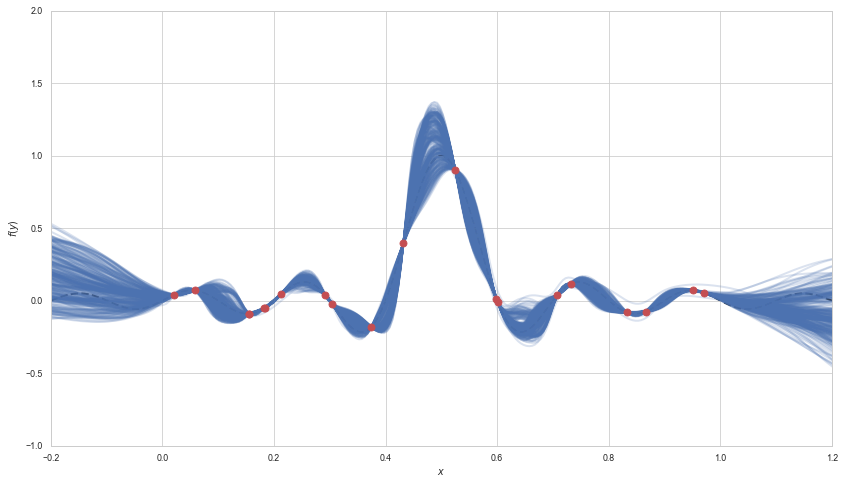

In [9]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14, 8))

all_preds = []

for weights in weight_samples[:]:
    
    bnn.set_weights(weights)
    
    pred = bnn((grid[:, None] - x_mean) / x_std).numpy()[:, 0]
    pred = y_std * pred + y_mean
    
    ax.plot(grid, pred, c='b', alpha=0.2, zorder=1)
    
    all_preds.append(pred)

all_preds = tf.stack(all_preds, axis=0)

ax.plot(grid, fvals, linestyle='--', c='k', zorder=0)
ax.scatter(x, y, marker='o', c='r', zorder=2, s=50)

ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

plt.savefig("samples.png")

plt.show()

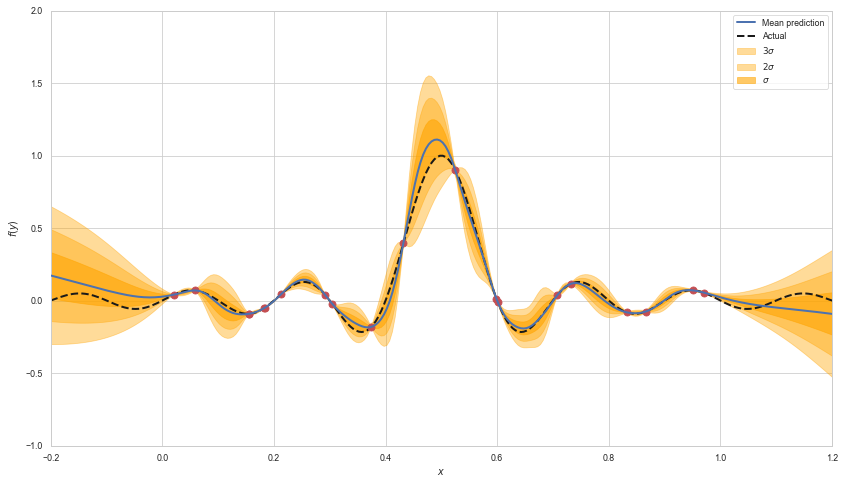

In [10]:
mean_pred, var_pred = tf.nn.moments(all_preds[30:, :], axes=[0])

fig, ax = plt.subplots(figsize=(14, 8))

std_pred = tf.sqrt(var_pred)

ax.plot(grid, mean_pred, linestyle='-', c='b', zorder=4, label="Mean prediction")
ax.fill_between(grid, 
                mean_pred + 3. * std_pred, 
                mean_pred - 3. * std_pred, 
                alpha=0.4, label="$3\sigma$", color='orange')

ax.fill_between(grid, 
                mean_pred + 2. * std_pred, 
                mean_pred - 2. * std_pred, 
                alpha=0.4, label="$2\sigma$", color='orange')

ax.fill_between(grid, 
                mean_pred + std_pred, 
                mean_pred - std_pred, 
                alpha=0.6, label="$\sigma$", color='orange')

ax.plot(grid, fvals, linestyle='--', c='k', zorder=2, label="Actual")
ax.scatter(x, y, marker='o', c='r', zorder=3, s=50)

ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-1., 2.])
ax.set_xlabel("$x$")
ax.set_ylabel("$f(y)$")

ax.legend()

plt.savefig("statistics.png")

plt.show()